In [1]:
import torch
import matplotlib.pyplot as plt
from fitting import create_ensemble, load_data, create_datasets


labels = ["x (mm)", r"$p_x$ (mrad)","y (mm)",r"$p_y$ (mrad)",
          "z (mm)",r"$\delta\ (10^{-3})$"]

tkwargs = {"dtype": torch.float}
save_dir = "double_small_emittance_case_cov_term_no_energy_spread/"
quad_strengths, image_data, bins, xx, gt_beam = load_data()
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

traces = torch.load(save_dir + "/loss_log.pt")
losses = torch.stack([ele[0] for ele in traces])
cov_trace = torch.stack([ele[1] for ele in traces])



In [27]:
# get predicted covariances


# iteration number
t = torch.arange(len(cov_trace))

# get gt cov
gt_cov = torch.cov(gt_beam.T)
gt_rms = torch.diag(gt_cov).sqrt()

trace_rms = torch.diagonal(cov_trace, dim1=-1, dim2=-2).sqrt()

# calculate learning rate
initial_lr = 0.01
n_models = 20
total_iterations = len(t)
train_period = int(total_iterations / n_models)

lr = 0.5*initial_lr * (torch.cos(3.14*torch.remainder(t-1,train_period) / train_period) + 1.0)
lr = torch.clip(lr, 0.0001)

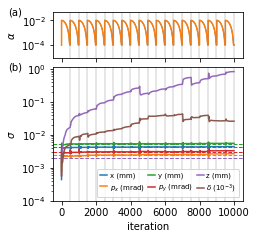

In [31]:
# plot emit_x


fig,(ax_lr, ax) = plt.subplots(
    2,1, sharex="all",
    gridspec_kw={
        "right": 0.975,"hspace":0.1,"left":0.2,"top":0.975,"bottom":0.1,
        "height_ratios":[0.35,1.]
    })
fig.set_size_inches(3.4,3.)
lw=1.0
mean_energy = 1
emit_scale = 1e6
ax_lr.plot(t, lr,lw=lw)
ax_lr.set_yscale("log")
ax_lr.set_ylabel(r"$ \alpha $")
colors = [f"C{i}" for i in range(6)]

ax_lr.plot(t, lr)

for i in range(6):
    ax.semilogy(t, trace_rms[:,i].cpu().detach(), label=labels[i],c=colors[i])
    ax.axhline(gt_rms[i].cpu().detach(),ls='--',c=colors[i],lw=lw)

# add locations of snapshots
for ele in t[train_period::train_period-1]:
    for a in [ax_lr, ax]:
        a.axvline(ele, c = "C7",alpha=0.25)
    
ax.set_ylabel("$\sigma$ ")
ax.set_xlabel("iteration")
fontsize = 7
handletextpad = 0.4
ax.legend(ncol=3, handlelength=1.0, columnspacing=0.5, fontsize=fontsize, handletextpad=handletextpad,loc=4)
ax.set_ylim(1e-4, 1.12)
ax_lr.set_ylim(0.8e-5,5e-2)
letters = "abc"
for a, l in zip((ax_lr,ax),letters):
    a.text(-0.2, 1.0, f"({l})", ha='center',
                       va='center', transform=a.transAxes)
#fig.savefig("convergence.svg")
#fig.savefig("convergence.png", dpi=300)


